# QuDiPy tutorial: using the charge stability module

This tutorial will show how to use the charge stability module to generate a charge stability diagram using the constant interaction model and then perform the Hough transformation.

This tutorial will be updated to include the generation of the charge stability diagrams using the Hubbard model and also the extraction of parameters from the Hough transformation.

In order for the file to not be too large, the output of the cells has been cleared so you will need to run the cells on your local machine to see the output.
In order for the size of this tutorial to not be too large, the output of the cells has been removed, so you will need to generate the figures on your local machine by running all the cells.

## 1. Add the current location to path
In order for this tutorial to work, you will need to run this from the tutorials folder.

In [16]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

## 2. Import the relevant modules

In [17]:
#From module
import qudipy.chargestability.csd_gen as gen
import qudipy.chargestability.csd_analysis as an
#For data maniupulation
import numpy as np
import pandas as pd
#For plotting
import seaborn as sb
import matplotlib.pyplot as plt

## 3. Specify the capacitance of the system you wish to simulate and then initialize the charge stability diagram object
In this tutorial, we will be simulating a double quantum dot system. The parameters follow the naming convention of https://doi.org/10.1103/RevModPhys.75.1. 
The first three parameters are the coupling of the first dot to the left resevoir, $c_l$, the coupling of the second dot to the right resevoir, $c_r$ and the coupling between the dots $c_m$.
The next two parameters are capacitances between gates and dots. $c_{g1}$ is the coupling between dot 1 the plunger gate $V_1$ and $c_{g2}$ is the coupling between dot 2 the plunger gate $V_2$.
These parameters are all that is required to define the system.

In [18]:
# Dot capacitances
c_l = 51 * 10**-18
c_r = 50 * 10**-18
c_m = 5 * 10**-18
# Dot-to-gate capacitances
c_g1 = 1 * 10**-18
c_g2 = 1 * 10**-18
# Initialize Object
csd = gen.CSD(c_l, c_r, c_m, c_g1, c_g2)

## 4. Generate the charge stability diagram and then plot the resulting diagram
The paramaters used to generate the charge stability diagram are as follows;
num: Nunmber of points to sweep each plunger voltage by. The resulting charge stability diagram will by num*num in size
v1(2)_max: Maximum voltage to sweep gate 1(2) to. By default, both voltages start at 0 volts, but this can be changed using a keyword argument.
c_cs_1(2): The coupling between the charge sensor (cs) and dot 1(2). This parameter dictates how much a change in the charge of one dot will change the current passing through a charge sensor coupled to both dots. In order for the (n,m)-(n+1,m-1) charge transitions to be visible, we should have c_cs_1 $\neq$ c_cs_2 (this is almost always the case in experiments). This current is arbitrary, but simulates what would be seen in an experiment. If you do not pass c_cs_1(2), then a colorbar will be created that matches each charge occupation (n,m) to a unique color.

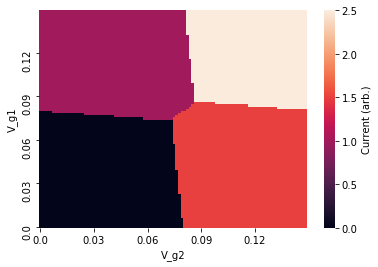

In [19]:
# Generate charge stability diagram
num=100
v1_max = 0.15
v2_max = 0.15
c_cs_1 = 1
c_cs_2 = 1.5

csd.generate_csd(v1_max, v2_max, c_cs_1, c_cs_2, num=num)
# Plot using seaborn
p = sb.heatmap(csd.csd, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5), cbar_kws={'label': 'Current (arb.)'})
p.axes.invert_yaxis()
plt.show()

## 5. Find the edges of the charge stability diagram
In order for the Hough transform to be used, we need to have a bitmap of where edges are and aren't in the image. So, we need to run some pre-processing to first find the edges, and then transform that map of edges into a bitmap.

In order to find the edges, we can take the derivative of the above charge stability diagram. This is done automatically when csd.generate_csd() is called, and is stored in csd.csd_der.

In [ ]:
q = sb.heatmap(csd.csd_der, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5), cbar_kws={'label': 'Current (arb.)'})
q.axes.invert_yaxis()
plt.show()

## 6. Create bitmap from edge data
From that image, we can create a bitmap.

Note that in an actual experiment, the data won't be so clean, so there will be some aditional noise. Fortunately the Hough transform is relatively robust to random noise, but a more quantitative assessement is necessary before deployement. In addition, there is a threshold parameter in the bitmap generation function that allows any noise below a certain level to be ignored, which can help clean up some data as well.

For the purposes of this tutorial, I  will be artificially adding noise to this bitmap to demonstrate that the Hough transform still perfroms as intended. However, in practice this would not be required (since the data will already be noisy)ired (since the data from an experiment would already be noisy).

In [ ]:
# Generate analysis object, and then use it to generate the bitmap
csd_an = an.CSDAnalysis(csd.csd_der)
csd_an.generate_bitmap(0.1)

# Plot using seaborn
r = sb.heatmap(csd_an.csd_bitmap, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5))
r.axes.invert_yaxis()
plt.show()


# Adding artificial noise (Will not be needed in practice)
np.random.seed(469230) # fix seed for reproducibility

noise = np.random.rand(*csd_an.csd_bitmap.shape) 
error = 0.05 # error rate of 5%

for index, value in np.ndenumerate(noise):
            if value < error:
                noise[index] = 1
            else:
                noise[index] = 0

noise_df = csd_an.csd_bitmap.copy()
noise_df[:] = noise

csd_an.csd_bitmap = csd_an.csd_bitmap + noise_df

r = sb.heatmap(csd_an.csd_bitmap, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5), vmax=1)
r.axes.invert_yaxis()
plt.show()
, vmax=1, vmax=1

Now all the data points that are 0 are set to be ignored when we perform the Hough transform and all the non-zero ones will be included.

## 7. Perform the Hough transform

For some background on the Hough transform, see the wikipedia article (https://en.wikipedia.org/wiki/Hough_transform, Theory and Examples section were most useful for me) and this tutorial that I found particularily useful (https://alyssaq.github.io/2014/understanding-hough-transform/)



In [ ]:
# Function which performs the Hough transform
accumulator, thetas, rhos = csd_an.hough_transform()

# Round ranges to not clutter the plotting area to much
rhos = np.round(rhos, 3)
thetas = np.round(thetas, 3)

# Create pandas DataFrame for easy of plotting, then plot
df = pd.DataFrame(accumulator, index=rhos, columns=thetas)
s = sb.heatmap(df, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5), cbar_kws={'label': 'Counts'})
s.axes.invert_yaxis()
s.axes.set_xlabel(r'$\theta$ (rad)')
s.axes.set_ylabel(r'$\rho$ (V)')
plt.show()

The spots where the counts in the color bar are the highest places where lines fit the best. We can see that there are 4 peaks that roughly make a rectangle in the upper right hand side of the graph. These correspond to the 4 large occupation transitions seen in the earlier charge stability diagram.
We can convert from these polar coordiantes to the normal slope and intercept using $m = \frac{-\text{cos}(\theta)}{\text{sin}(\theta)}$ and $b = \frac{\rho}{\text{sin}(\theta)}$.

## 8. Peak Finding

Next, we need to figure out where the peaks are in order to extract the best fitting lines. In order to do this, we first apply a threshold to function to the Hough transformed result.

In [ ]:
accumulator_threshold = csd_an.threshold_hough_accumulator(threshold=35, threshold_type='absolute')

df1 = pd.DataFrame(accumulator_threshold, index=rhos, columns=thetas)
s = sb.heatmap(df1, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5))
s.axes.invert_yaxis()
s.axes.set_xlabel(r'$\theta$ (rad)')
s.axes.set_ylabel(r'$\rho$ (V)')
plt.show()

From this thresholded accumulator, we can cluster them into groups, determine the centroid of each group and then get the lines which correctly fit the charge stability diagram.

## 9. Future work

As discussed in the previous section, we still need to implement clustering in order to find the lines which best fit the charge stability diagram. This functionality will be added and this tutorial updated correspondingly.